# The Task at Hand

Have you ever wondered if computers could translate languages? Did you think google translate or duolingo worked because they memorized answers? 

The type of problem that translation solves is sequence to sequence. For instance, we could convert an english input sequence to a german output sequence. 

In this activity, we will create an english -> chinese translator and apply what we've been learning about LSTMs & RNNs.

## Preparing the data
We need to import our packages and data to learn a little bit about the problem at hand.

In [1]:
import numpy as np
import torch.nn as nn
from nltk.tokenize import WordPunctTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Word2Sequence import Word2Sequence
from Dataset import Dataset
from Seq2Seq import Seq2Seq

In [2]:
# read small_en-cn.txt file
data_path = './eng-chin.txt'
df = pd.read_table(data_path,header=None).iloc[:,:]
df = df.drop([2],axis=1)
df.columns=['english','chinese']

input_texts = df.english.values.tolist() #this will be all of the english sentences
target_texts = df.chinese.values.tolist() #this will be all of the chinese sentences

In [5]:
'''
Your code here: Try printing some english and chinese sentences from their lists input_texts and target_texts!
'''
import random
rn = random.randint(0, 98)
print(input_texts[rn], target_texts[rn])

I thought that we had found the perfect hiding place, but the police found us. 我以为我们发现了绝妙的藏身之处，但警察找到了我们。


In [6]:
#read in our model object. Tokenize our data
tk = WordPunctTokenizer()
english = [tk.tokenize(sentence.lower()) for sentence in input_texts]
chinese = [[x for x in sentence] for sentence in target_texts]

In [7]:
'''
Your code here: Explore this data. Can you calculate the maximum length of a sequence in each dataset english and chinese?
'''
# calculate max_len of any sequence in 'english' list and save it to a variable called max_english_length
max_english_length = 0
for sentence in english:
    if len(sentence) > max_english_length:
        max_english_length = len(sentence)

# calculate max_len of any sequence in 'chinese' list and save it to a variable called max_chinese_length
max_chinese_length = 0
for sentence in chinese:
    if len(sentence) > max_chinese_length:
        max_chinese_length = len(sentence)

print('max_english_length:', max_english_length)
print('max_chinese_length:', max_chinese_length)

max_english_length: 25
max_chinese_length: 39


In [12]:
input_tokenizer = Word2Sequence()
for words in english:
    input_tokenizer.fit(words)
input_tokenizer.build_vocab(min=1, max_features=None) #inpu

output_tokenizer = Word2Sequence()
for words in chinese:
    output_tokenizer.fit(words)
output_tokenizer.build_vocab(min=1, max_features=None)

'''
Your code here: print the total english words in your input tokenizer and total chinese words in your output tokenizer below!
'''
print('total english words:', input_tokenizer.__len__())
print('total chinese words:', output_tokenizer.__len__())

total english words: 199
total chinese words: 317


<h1>Creating the model</h1>

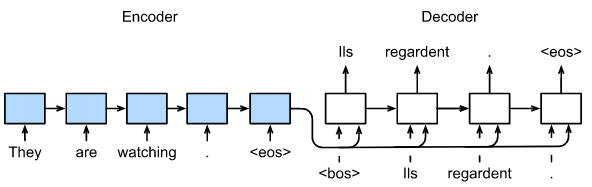

NOTE: For Structure of Encoder Inputs, they can all be either (assume all have same maxlen): 
1. \<SOS>, word1, word2, word3, ..., \<EOS>
2. word1, word2, word3, ..., \<EOS> 
3. word1, word2, word3, ...

NOTE: But Decoder In and Out structures should always look like this (assume all have same maxlen):
- Decoder Input: \<SOS>, word1, word2, word3, ...
- Decoder Output: word1, word2, word3, ..., \<EOS>  

This means that our input and ouput max length should be one more than the sequence's max length.

WHY? Data Structure:
- 1. Encoder Input: [word1, word2, ... + <EOS>]
- 2. Decoder Input: [<SOS> + word1, word2, ...]
- 3. Decoder Output:[word1, word2, ... + <EOS>]
    
nn docs - https://pytorch.org/docs/stable/nn.html

In [13]:
# Seq2Seq Parameters
in_maxlen = max_english_length + 1 # 25 + 1(<EOS> token)
out_maxlen = max_chinese_length + 1 # 39 + 1(<EOS> token or <SOS> token)
n_hidden = 32 # number of "neurons" per layer
d_model = 64 # number of embedding dimensions to represent each word
enc_n_class = len(input_tokenizer.dict) # OR... vocab size of englisth -> 199
dec_n_class = len(output_tokenizer.dict) # OR... vocab size of chinese -> 317
batch_size = 1

In [14]:
eng_maxlen = max_english_length + 1 # 25 + 1(<EOS> token)
chin_maxlen = max_chinese_length + 1  # 39 + 1(<EOS> token or <SOS> token)
batch_size = 1 

# Setup the Dataset.
dataset = Dataset(
    X = english,
    Y = chinese,
    in_tknz = input_tokenizer, out_tknz = output_tokenizer,
    in_maxlen = eng_maxlen, out_maxlen = chin_maxlen
)

'''
The following are helper functions to help pytorch. You won't need to know this much.
'''
# NOTE: collate_fn preprocesses your input from PyTorch Dataset above during PyTorch DataLoader
def collate_fn(batch):
    '''
    param batch: ([enc_in, dec_in, dec_out]， [enc_in, dec_in, dec_out], output of getitem...)
    '''
    # unpack values
    enc_in, dec_in, dec_out = list(zip(*batch))
    # Return tensor type
    return torch.LongTensor(enc_in), torch.LongTensor(dec_in), torch.LongTensor(dec_out)

def get_dataloader(dataset, batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn):
    '''
    Returns a way to access and use the data
    '''
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            collate_fn=collate_fn)
    return dataloader
# Get PyTorch DataLoader
dataloader = get_dataloader(dataset, batch_size)
dataloader = get_dataloader(dataset, batch_size)

In [15]:
model = Seq2Seq(
    in_maxlen = in_maxlen,
    out_maxlen = out_maxlen,
    n_hidden = n_hidden,
    enc_n_class = len(input_tokenizer.dict),
    dec_n_class = len(output_tokenizer.dict),
    d_model = d_model,
    num_layers = 1,
)
model.to(device)
# # If you have saved a model before
# model.load_state_dict(torch.load("seq2seq.pt", map_location=device))

/projects/b9e0cba5-06d0-4604-824f-bbb5d6223324/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Seq2Seq(
  (encoder): GRU(64, 32, dropout=0.3)
  (decoder): GRU(64, 32, dropout=0.3)
  (embed_enc): Embedding(199, 64)
  (embed_dec): Embedding(317, 64)
  (fc): Linear(in_features=32, out_features=317, bias=True)
)

In [16]:
# Define Loss and Optimizer -- these are ways we define performance for our model. If you're curious: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

<h1>Training our model</h1>

In [18]:
'''
Your code here: change the number of epochs to see how it effects training time and quality
'''
epochs = 256

'''
Training -- no need to touch the code below.
'''
torch.cuda.empty_cache()
model.train()
model.to(device)
loss_records = []


for epoch in range(epochs):
    # runs the model and calculates loss
    loss = 0
    for _, (enc_in, dec_in, dec_out) in enumerate(dataloader):
        # enc_h_0.shape: [1(num_layers), 1(batch_size), 32(hidden_size)]
        enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
        # To Cuda Device if available
        enc_in, dec_in = enc_in.to(device), dec_in.to(device)

        pred = model(enc_in, enc_h_0, dec_in)

        dec_out = dec_out.to(device)
        for i in range(len(dec_out)): # dec_in.shape: [1(b), 40(out_maxlen)]
            # pred[i].shape: [40(out_maxlen), 317(dec_n_class)]
            # dec_out[i].shape: [40(out_maxlen)]
            loss += criterion(pred[i], dec_out[i])

    if (epoch) % 1 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")

    if (epoch) % 100 == 0:
        loss_records.append(loss)

    # runs the actual back propacation
    optim.zero_grad()
    loss.backward()
    optim.step()
    torch.save(model.state_dict(), "seq2seq.pt")

Epoch: 0, Loss: 509.718017578125


Epoch: 10, Loss: 264.8349914550781


Epoch: 20, Loss: 231.07916259765625


Epoch: 30, Loss: 208.9425506591797


Epoch: 40, Loss: 185.1838836669922


Epoch: 50, Loss: 160.76028442382812


Epoch: 60, Loss: 137.586669921875


Epoch: 70, Loss: 116.52574920654297


Epoch: 80, Loss: 98.19603729248047


Epoch: 90, Loss: 82.4125747680664


Epoch: 100, Loss: 69.05858612060547


Epoch: 110, Loss: 57.92717742919922


Epoch: 120, Loss: 48.682456970214844


Epoch: 130, Loss: 41.15633773803711


Epoch: 140, Loss: 34.785518646240234


Epoch: 150, Loss: 29.802488327026367


Epoch: 160, Loss: 25.404434204101562


Epoch: 170, Loss: 21.672164916992188


Epoch: 180, Loss: 20.304332733154297


Epoch: 190, Loss: 16.60958480834961


Epoch: 200, Loss: 14.172014236450195


Epoch: 210, Loss: 12.277118682861328


Epoch: 220, Loss: 10.744781494140625


Epoch: 230, Loss: 9.579378128051758


Epoch: 240, Loss: 8.83117389678955


Epoch: 250, Loss: 7.687771797180176


## Let's check out our model's progress
No need to change the code below, this will plot our loss over time. How do you think we can tweak our code to decrease loss even further?

In [19]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points): # Helper function for showing our plots
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

<Figure size 432x288 with 0 Axes>

Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2728 ticks ([-10.8, ..., 534.6]), which exceeds Locator.MAXTICKS (1000).


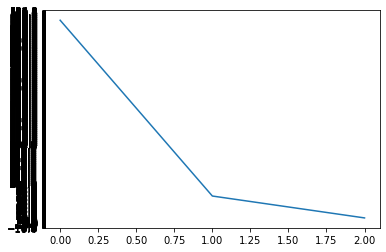

In [20]:
showPlot([loss.cpu().item() for loss in loss_records])

<h1>Code for Translating with our Model</h1>
This is where the Seq2Seq happens after the model is trained.


In [22]:
'''
No need to touch this code: 
'''

def translate(eng_sent, model, device):
    # set up the inputs and variables
    model.eval()
    model.to(device)
    eng_sent = tk.tokenize(eng_sent.lower()) + ["<EOS>"]
    eng_sent = input_tokenizer.transform(eng_sent, max_len=in_maxlen, pad_first=False)
    dec_in = (["<SOS>"] + ["<PAD>"]*out_maxlen)[:out_maxlen]
    dec_in = output_tokenizer.transform(dec_in, max_len=out_maxlen, pad_first=False)
    
    enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
    eng_sent, dec_in = torch.LongTensor(eng_sent), torch.LongTensor(dec_in)

    eng_sent = eng_sent.unsqueeze(0)
    dec_in = dec_in.unsqueeze(0)
    eng_sent, dec_in = eng_sent.to(device), dec_in.to(device)

    # run the model
    with torch.no_grad():
        # eng_sent: [1(b), 26(in_maxlen)]
        embedded_X = model.embed_enc(eng_sent)
        # embedded_X: [26(in_maxlen), 1(b), 64(d_model)] <- [1(b), 26(in_maxlen), 64(d_model)]
        embedded_X = embedded_X.permute(1, 0, 2)
        _, memory = model.encoder(embedded_X, enc_h_0)
        pred_loc = 0
        for i in range(out_maxlen-1):
            embedded_Y = model.embed_dec(dec_in)
            embedded_Y = embedded_Y.permute(1, 0, 2)
            outputs, _ = model.decoder(embedded_Y, memory)
            outputs = outputs.permute(1, 0, 2)
            pred = model.fc(outputs)
            pred = pred[0][pred_loc].topk(1)[1].item()
            pred_loc += 1
            if pred == 2:
                dec_in[0][pred_loc] = pred
                break
            else:
                dec_in[0][pred_loc] = pred
    return dec_in

# Using our Model in Practice
Check out these examples below. This is how you can translate sequences!

In [33]:
import random
eng_sents = random.sample(input_texts, 28)
for sent in eng_sents:
  translated = translate(sent, model, torch.device("cpu"))
  translated_sent = output_tokenizer.inverse_transform(translated[0], is_tensor=True)
  translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word != "<PAD>"])
  print(f"{sent} -> \n{translated_sent}")

We apologize for the delay and regret any inconvenience it may have caused. -> 
我们对这次的延<UNK>表示<UNK><UNK>，并对可能<UNK>成的不便表示<UNK><UNK>。
You seem to be prejudiced against ideas that come from foreign countries. -> 
你<UNK><UNK>我吃完這個<UNK>我就會<UNK>得<UNK>服一<UNK>。


In the U.S., most people can vote when they reach eighteen years of age. -> 
在美国，大多数人能在十八岁后<UNK><UNK><UNK><UNK><UNK><UNK><UNK><UNK>。
Tom always speaks in such a low voice that I can barely understand what he says. -> 
汤姆总是说话<UNK>音<UNK><UNK>，我几乎听不懂他在说什么。


The world is just like a book, and every step you take is like turning a page. -> 
世界就像是一本书，<UNK>一<UNK>等于<UNK>了一<UNK>。
You shouldn't share too much private information on the social networks. -> 
你不<UNK>该在社交<UNK><UNK>上分<UNK><UNK>多<UNK>人信<UNK>。


You're much less likely to get a good position if you don't speak English. -> 
如果你不会说英语，你就很难得到一个好的<UNK>位。
If a sick person folds one thousand paper cranes, her wish will come true. -> 
如果一個<UNK>人<UNK>一<UNK><UNK><UNK><UNK>, 她的<UNK>望就會成真。


While I was reading in bed last night, I fell asleep with the light on. -> 
我昨晚在<UNK>上看书的时候点着<UNK>就<UNK>了。
A person views things differently according to whether they are rich or poor. -> 
每一個人對事情的看法不同是<UNK>據他們是富有<UNK>是貧窮。


Does any other country fan the flames of patriotism as much as America? -> 
有没有一个国家比美国更提<UNK>爱国<UNK><UNK>？
After he had graduated from the university, he taught English for two years. -> 
<UNK>他大學<UNK>業以後, 他教了<UNK>年的英語。
She visits the dentist on a regular basis, so she seldom gets toothaches. -> 
她定<UNK>去看牙<UNK>，所以她很少牙<UNK>。


I learned to drive a car when I was eighteen and got a driver's license. -> 
我十八歲時，學了開車、考到了駕照。
By the way, did you find the umbrella you said you'd lost the other day? -> 
对了，前些时间你说<UNK>不见了，现在找到了吗？


I don't have a lot of work, but it's enough to keep me in the office this week. -> 
其<UNK>我工作并不多，但足以让我这周在<UNK>公<UNK>里<UNK>着了。
The ages of the two children put together was equivalent to that of their father. -> 
<UNK><UNK>写的人口。
I returned the books I borrowed from the library, and I borrowed some new ones. -> 
我还了从图书馆借的书，<UNK>借了些新的。


I learned to drive a car and got a driver's license when I was eighteen. -> 
我十八歲時，學了開車、考到了駕照。
Three out of four Americans believe in the existence of paranormal phenomena. -> 
<UNK>分之<UNK>的美国人相信存在<UNK>自然现<UNK>。
It's hard to believe that Tom wasn't aware that Mary was in love with him. -> 
真难相信汤姆不知道玛丽爱他。


Rather than cutting down on cigarettes, why don't you just give them up? -> 
比起少<UNK>菸，你何不直接把菸<UNK>了？
We were talking about something at that time, but I don't remember what. -> 
我们那时在<UNK>论事情，但我不记得是什么了。
Kindness is the language which the deaf can hear and the blind can see. -> 
<UNK>良是<UNK>子能<UNK><UNK>人能看的語言。


If it looks like an apple and it tastes like an apple, it's probably an apple. -> 
如果看起来像个苹果而且吃起来也像苹果的话，可能就是苹果。
Being a good conversationalist does not just mean being a good speaker of English. -> 
作為一個良好的交<UNK>者，<UNK>不只意<UNK><UNK>作一個英語說得好的說話者。


English has now become the common language of several nations in the world. -> 
英语现已成为世界上<UNK>多国家的通用语言了。
Tom can write almost like a native speaker, but his pronunciation is terrible. -> 
<UNK><UNK><UNK>写作可以写的像本国人一<UNK>，可是他的发音很<UNK><UNK>才<UNK><UNK>。


# Your turn!
Can you use the code in the cell above to translate custom sentences? 

In [30]:
'''
Your code here: translate custom sentences using the code above. Hint: You won't need a for loop!
'''
translated = translate("translate custom sentences using the code above", model, torch.device("cpu"))
translated_sent = output_tokenizer.inverse_transform(translated[0], is_tensor=True)
translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word != "<PAD>"])
print(f"translate custom sentences using the code above -> \n{translated_sent}")

translate custom sentences using the code above -> 
我们在<UNK>上看书的时候点着<UNK>就<UNK>了。
